# Answering Business Questions using SQL
* With the Chinook database provided as a SQLite database file called chinook.db. See the schema in my github repo.
* Note: the database retains 'state', so if I run a query with a CREATE or DROP twice, the query will fail. In case of trouble, or if the db is locked there is a copy chinook-unmodified.db
* Goal: answer to business questions

#### Few tips to keep in mind while working on queries:
* Write your query in stages, and run it as you go to make sure at each stage it's producing the output you expect.
* If something isn't behaving as you expect, break parts of the query out into their own, separate queries to make sure there's not an inner logic error.
* Don't be afraid to write separate queries to check the underlying data, for instance you might write a query that you can use to manually check a calculation and give yourself confidence that the output you're seeing is correct.

### Creation of helper functions

In [41]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import cm

# to make sure any plots render in the notebook
%matplotlib inline  

* The helper functions in python will save some time.
* I'll use a context manager to handle the connection to the SQLite database.
Context managers make life easy by taking care of opening and closing the connection to the database, as well as making sure accidentally no change is made to the database if one of our queries has an error.
See this excellent article by Jeff Knupp https://jeffknupp.com/blog/2016/03/07/python-with-context-managers/

In [42]:
db = 'chinook.db'

# func that takes a SQL query as an arg, returns a df of that query.
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

# func that takes a SQL command as an arg, executes it using the sqlite module.
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

# functon that calls the run_query() function to return a list of all tables & views in the database.
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)


show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Selection of new albums to purchase
The Chinook record store has just signed a deal with a new record label. Task: selects the first three albums that will be added to the store, from a list of four. 
The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so find out which genres sell the best in the USA.

In [43]:
# returns each genre, with the number of tracks sold in absolute numbers and in percentages
tracks_sold_per_genre = '''
WITH tracks_sold_usa AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(tsu.invoice_line_id) tracks_sold,
    ROUND(cast(count(tsu.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from tracks_sold_usa
    )*100,1) percentage_sold
FROM tracks_sold_usa tsu
INNER JOIN track t on t.track_id = tsu.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY genre
ORDER BY percentage_sold DESC
LIMIT 10;
'''

run_query(tracks_sold_per_genre)

,genre,tracks_sold,percentage_sold
0,Rock,561,53.4
1,Alternative & Punk,130,12.4
2,Metal,124,11.8
3,R&B/Soul,53,5.0
4,Blues,36,3.4
5,Alternative,35,3.3
6,Latin,22,2.1
7,Pop,22,2.1
8,Hip Hop/Rap,20,1.9
9,Jazz,14,1.3


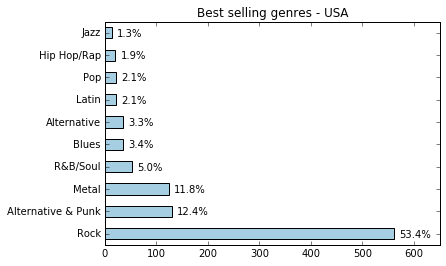

In [53]:
genre_sales = run_query(tracks_sold_per_genre)
genre_sales.set_index("genre", inplace=True, drop=True)

genre_sales["tracks_sold"].plot.barh(
    title="Best selling genres - USA",
    xlim=(0, 650),
    colormap=plt.cm.Paired
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales.index)):
    score = genre_sales.loc[label, "tracks_sold"]
    label = (genre_sales.loc[label, "percentage_sold"]
            ).astype(float).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

##### Recommendation
If the 3 new albums among the following 4 are choosen according to the best selling genres: 
* Artist Name (Genre)
* Regal (Hip-Hop)
* Red Tone (Punk)
* Meteor and the Girls (Pop)
* Slim Jim Bites (Blue)

I would purchase Red Tone (Punk), Slim Jim Bites (Blues) & Meteor and the Girls (Pop) based on the map above.

### Analysis of the employee sales performance
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. Analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

In [46]:
# finds the total dollar amount of sales assigned to each sales support agent within the company
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


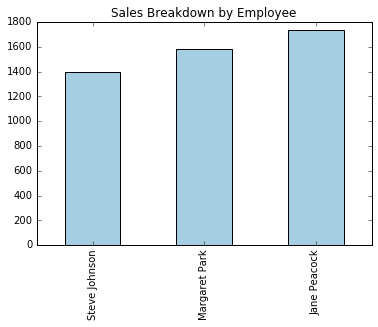

In [54]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.bar(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Paired
)
plt.xlabel('')
plt.show()

The best "seller' have been hired earlier. There isn't any real difference between the performances of these 3 employees.

### Analysis of the sales by country
* Analyze the sales data for customers from each different country. Use the country value from the customers table, and ignore the country from the billing address in the invoice table.
* Calculate data, for each country, on the:
    * total number of customers
    * total value of sales
    * average value of sales per customer
    * average order value
Where a country has only one customer, collect them into an "Other" group.
The results aresorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

In [48]:
# collates data on purchases from different countries
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


### Visualisation of the sales by country

* Create a series of visualizations which communicate the previous findings, and then make recommendations on which countries may have potential for growth.

When working with data that has many dimensions, it can be tempting to try and communicate every dimension in a single plot. This often results in complex and hard to read visualizations. Instead of this, create different plots for each dimension.

Side note: Think about the best way to communicate the data - this includes not only plot types, but how you use color, spacing and layout. As an example, you might decide to use the same color across your four plots to represent each country, so it's easier to understand the chart as a whole.

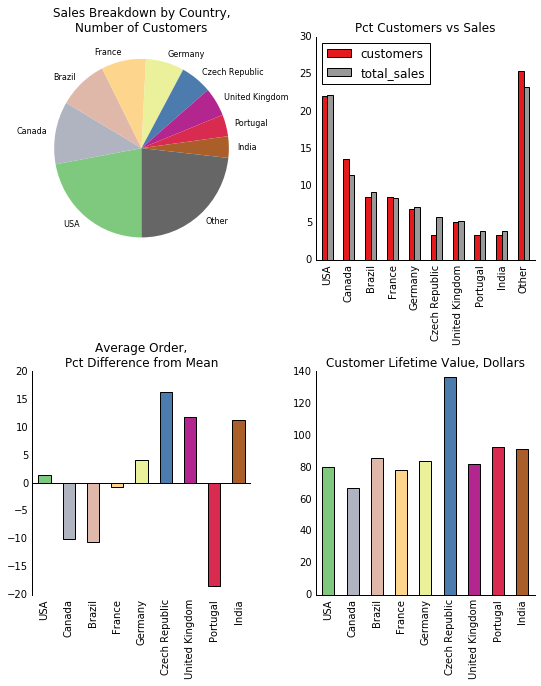

In [49]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Because the amount of data from each of these countries is relatively low, the sample size is not large enough to be relevant. Anyway, based on the data, there may be opportunity in the following countries:
* Czech Republic
* United Kingdom
* India



### Percentage of purchases for individual tracks vs whole albums
The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:
* purchase a whole album
* purchase a collection of one or more individual tracks.
The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

-> Find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.



In [50]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


##### Based on this data, the album purchases account for only 18% of purchases. It seems that 'purchasing only selected tracks from albums' is not an interesting strategy.

### Summary
In this project I put my SQL joining skills to the test, using subqueries, multiple joins, set operations, aggregate functions and more.
* Python/SQL concepts explored: python+sqlite3, pandas, data visualization with matplotlib
* Functions, methods, and properties used: pd.read_sql(,), conn.execute(), plot.bar() & plot.barh(), plot.pie()
* SQL statements used: SELECT, FROM, SUM(), INNER JOIN, GROUP BY, ORDER BY

### Further investigations - Some more business questions
* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?